# Implementação modelo UNet

#### Visualização:

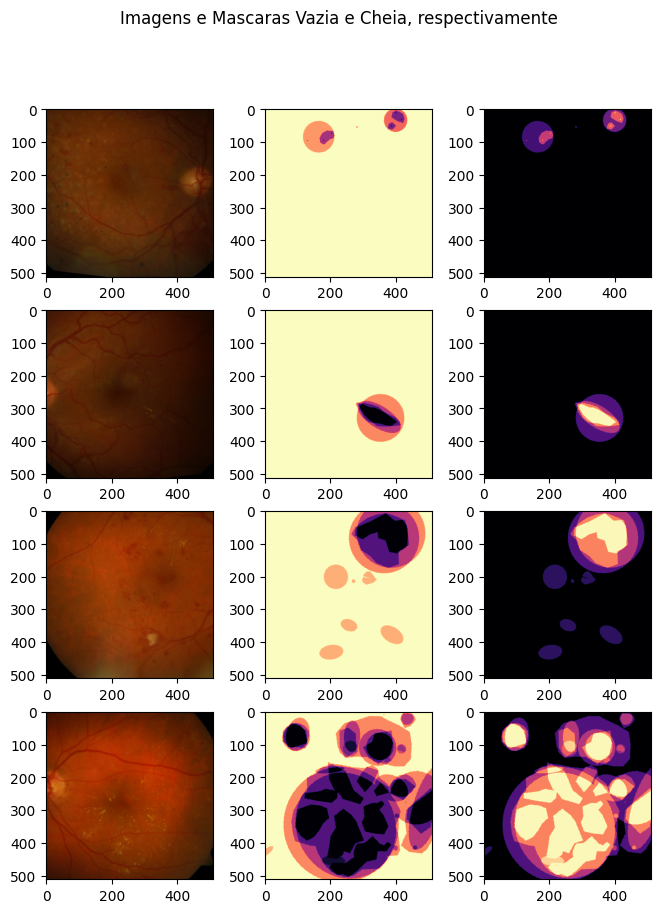

UM LOTE OBTIDO. SHAPES:
inputs_shape: torch.Size([4, 3, 576, 750])
true_masks_shape: torch.Size([4, 2, 576, 750])


In [9]:
import dataset
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from transform.transforms_group import *
import torch
from config import *

RESOURCES_PATH = Path("datasets/diaretdb1_v_1_1/resources")
batch_size = BATCH_SIZE
img_dir = IMAGES_DIR
mask_dir = MASKS_DIR
train_data = dataset.dr_dataset(Path(RESOURCES_PATH/"traindatasets/trainset.txt"),
                                img_dir,
                                mask_dir,
                                0,  Compose([RandomRotation(ROTATION_ANGEL),RandomCrop(image_size),]))
test_data = dataset.dr_dataset( Path(RESOURCES_PATH/"testdatasets/testset.txt"),
                                img_dir,
                                mask_dir,
                                0, None)

train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)


"""Buscar 4 imagens de forma aleatória do conjunto de dados e as exibe um uma figure:"""
fig, axes = plt.subplots(4,3, figsize=(8,10))
fig.suptitle("Imagens e Mascaras Vazia e Cheia, respectivamente")
for lin in range(4):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    image, masks = train_data[sample_idx]
    axes[lin,0].imshow(np.transpose(image,(1,2,0)))
    # axes[lin,0].set_title('Imagem')
    axes[lin,1].imshow(masks[0], cmap='magma')
    # axes[lin,1].set_title('Máscara')
    axes[lin,2].imshow(masks[1], cmap='magma')
    
plt.show()

# teste para treino:
print("UM LOTE OBTIDO. SHAPES:")
inputs, true_masks = next(iter(test_dataloader))
print(f"inputs_shape: {inputs.shape}\ntrue_masks_shape: {true_masks.shape}")

#### Treino:

##### Imports:

In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# **************************************
# @Author  : Qiqi Xiao & Jiaxu Zou
# @Email     : xiaoqiqi177@gmail.com & zoujx96@gmail.com
# @File    : train.py
# **************************************

import sys; from pathlib import Path ; import argparse
# from tqdm import trange
import numpy as np
import random
import matplotlib.pyplot as plt
from unet_model import *
from utils import *
from dataset import dr_dataset
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from transform.transforms_group import *
from torch.utils.data import DataLoader, Dataset


from sklearn.metrics import precision_recall_curve, average_precision_score
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from config import *

##### Funções para treino:

In [11]:
def eval_model(model, eval_loader):
    model.eval()
    masks_soft = []
    masks_hard = []

    with torch.set_grad_enabled(False):
        for inputs, true_masks in eval_loader:
            # inputs: imagens de avaliação
            # true_masks: mascaras dessas imagens

            inputs = inputs.to(device=device, dtype=torch.float)
            true_masks = true_masks.to(device=device, dtype=torch.float)
            bs, _, h, w = inputs.shape
            # not ignore the last few patches
            h_size = (h - 1) // image_size + 1
            w_size = (w - 1) // image_size + 1
            masks_pred = torch.zeros(true_masks.shape).to(dtype=torch.float)

            for i in range(h_size):
                for j in range(w_size):
                    h_max = min(h, (i + 1) * image_size)
                    w_max = min(w, (j + 1) * image_size)
                    inputs_part = inputs[:, :, i*image_size:h_max, j*image_size:w_max]
                    masks_pred_single = model(inputs_part)
                    masks_pred[:, :, i*image_size:h_max, j*image_size:w_max] = masks_pred_single

            masks_pred_softmax_batch = F.softmax(masks_pred, dim=1).cpu().numpy()
            masks_soft_batch = masks_pred_softmax_batch[:, 1:, :, :]
            masks_hard_batch = true_masks[:,1:].cpu().numpy()

            masks_soft.extend(masks_soft_batch)
            masks_hard.extend(masks_hard_batch)

    masks_soft = np.array(masks_soft).transpose((1, 0, 2, 3))
    masks_hard = np.array(masks_hard).transpose((1, 0, 2, 3))
    masks_soft = np.reshape(masks_soft, (masks_soft.shape[0], -1))
    masks_hard = np.reshape(masks_hard, (masks_hard.shape[0], -1))

    ap = average_precision_score(masks_hard[0], masks_soft[0])
    return ap

def denormalize(inputs):
    return (inputs * 255.).to(device=device, dtype=torch.uint8)

def generate_log_images(inputs_t, true_masks_t, masks_pred_softmax_t):
    true_masks = (true_masks_t * 255.).to(device=device, dtype=torch.uint8)
    masks_pred_softmax = (masks_pred_softmax_t.detach() * 255.).to(device=device, dtype=torch.uint8)
    inputs = denormalize(inputs_t)
    bs, _, h, w = inputs.shape
    pad_size = 5
    images_batch = (torch.ones((bs, 3, h, w*3+pad_size*2)) * 255.).to(device=device, dtype=torch.uint8)
    
    images_batch[:, :, :, :w] = inputs
    
    images_batch[:, :, :, w+pad_size:w*2+pad_size] = 0
    images_batch[:, 0, :, w+pad_size:w*2+pad_size] = true_masks[:, 1, :, :]
    
    images_batch[:, :, :, w*2+pad_size*2:] = 0
    images_batch[:, 0, :, w*2+pad_size*2:] = masks_pred_softmax[:, 1, :, :]
    return images_batch

def image_to_patch(image, patch_size):
    bs, channel, h, w = image.shape
    return (image.reshape((bs, channel, h//patch_size, patch_size, w//patch_size, patch_size))
            .permute(2, 4, 0, 1, 3, 5)
            .reshape((-1, channel, patch_size, patch_size)))


def train_model(model, lesion, preprocess, train_loader, eval_loader, criterion, g_optimizer, g_scheduler, 
    batch_size, num_epochs=5, start_epoch=0, start_step=0):
    model.to(device=device)
    tot_step_count = start_step

    best_ap = 0.
    dir_checkpoint = Path('results/models_'+lesion.lower())

    for epoch in range(start_epoch, num_epochs): #ADAPTAR PARA TRANGE
        """Aqui foi feita a seguinte modificação:
           for epoch in range(start_epoch, start_epoch + num_epochs) >>>> for epoch in range(start_epoch, num_epochs) """
        print('Starting epoch {}/{}.\t\n'.format(epoch + 1, num_epochs))
        g_scheduler.step() # TIRAR DUVIDA COM DEBORA E PEDRO:
        """PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure 
            to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate"""
        model.train()

        for inputs, true_masks in train_loader:
            inputs = inputs.to(device=device, dtype=torch.float)
            true_masks = true_masks.to(device=device, dtype=torch.float)
            print(f"INPUTS_shape: {inputs.shape} type: {type(inputs)}\nTRUE_MASK_shape: {true_masks.shape}type: {type(true_masks)} \n")
            masks_pred = model(inputs)
            print(f"MASKS PRED_shape: {masks_pred.shape} type: {type(masks_pred)}\n\n")
            masks_pred_transpose = masks_pred.permute(0, 2, 3, 1) # BS, C, H,W >>> BS, H, W, C
            masks_pred_flat = masks_pred_transpose.reshape(-1, masks_pred_transpose.shape[-1])
            true_masks_indices = torch.argmax(true_masks, 1)
            true_masks_flat = true_masks_indices.reshape(-1)
            loss_ce = criterion(masks_pred_flat, true_masks_flat.long())
            
            ce_weight = 1.
            g_loss = loss_ce * ce_weight

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            tot_step_count += 1
        
        if not dir_checkpoint.exists():
           dir_checkpoint.parent.mkdir()
           dir_checkpoint.mkdir()

        if (epoch + 1) % 1 == 0:
            eval_ap = eval_model(model, eval_loader)
            with open("ap_during_learning_" + lesion + preprocess + ".txt", 'a') as f:
                f.write("epoch: " + str(epoch))
                f.write("ap: " + str(eval_ap))
                f.write("\n")

            if eval_ap > best_ap:
                best_ap = eval_ap

                state = {
                    'epoch': epoch,
                    'step': tot_step_count,
                    'state_dict': model.state_dict(),
                    'optimizer': g_optimizer.state_dict(),
                    'loss': g_loss,
                    }

                torch.save(state, Path(dir_checkpoint, 'model_' + preprocess + '.pt'))

##### Treino Efetivos

In [20]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--seed', type=int, default=1234)
# parser.add_argument('--preprocess', type=str, default='7')
# parser.add_argument('--lesion', type=str, default='EX')
# args = parser.parse_args()
#Set random seed for Pytorch and Numpy for reproducibility
# random.seed(args.seed)
# np.random.seed(args.seed)
# torch.manual_seed(args.seed)

# seed, preprocess, lesion = args
seed, preprocess, lesion = int(input("Seed:")), input("Preprocess:"), input("Lesion:") 
 

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = UNet(n_channels=3, n_classes=2)
g_optimizer = optim.SGD(model.parameters(),
                          lr=LEARNING_RATE,
                          momentum=0.9,
                          weight_decay=0.0005)
resume = False
if resume:
    if resume.is_file():
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']+1
        start_step = checkpoint['step']
        model.load_state_dict(checkpoint['state_dict'])
        g_optimizer.load_state_dict(checkpoint['optimizer'])
        loss = checkpoint['loss']
        print('Model loaded from {}'.format(resume))
    else:
        print("=> no checkpoint found at '{}'".format(resume))
else:
    start_epoch = 0
    start_step = 0

train_image_paths, train_mask_paths = get_images(IMAGES_DIR.parent, preprocess, phase='train')
eval_image_paths, eval_mask_paths = get_images(IMAGES_DIR.parent, preprocess, phase='eval')

train_dataset = dr_dataset(ANNOTATIONS_TRAINING_PATH, IMAGES_DIR, MASKS_DIR, LESION_IDS[lesion], transform=
                        Compose([
                        RandomRotation(ROTATION_ANGEL),
                        RandomCrop(image_size),
            ]))
eval_dataset = dr_dataset(ANNOTATIONS_VALID_PATH, IMAGES_DIR, MASKS_DIR, LESION_IDS[lesion])

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, BATCH_SIZE, shuffle=False)

g_scheduler = lr_scheduler.StepLR(g_optimizer, step_size=200, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(CROSSENTROPY_WEIGHTS).to(device))

# train_model(model, args.lesion, args.preprocess, train_loader, eval_loader, criterion, g_optimizer, g_scheduler, \
#             BATCH_SIZE, num_epochs=EPOCHES, start_epoch=start_epoch, start_step=start_step)
train_model(model, lesion,preprocess, train_loader, eval_loader, criterion, g_optimizer, g_scheduler, \
            BATCH_SIZE, num_epochs=EPOCHES, start_epoch=start_epoch, start_step=start_step)

Seed: 765
Preprocess: 2
Lesion: EX


---- Funcao get_images() de utils.py concluida ----

---- Funcao get_images() de utils.py concluida ----

Starting epoch 1/2.	

INPUTS_shape: torch.Size([4, 3, 512, 512]) type: <class 'torch.Tensor'>
TRUE_MASK_shape: torch.Size([4, 2, 512, 512])type: <class 'torch.Tensor'> 



C:\Users\ermes\OneDrive\Área de Trabalho\Pesquisa-Segmentacao\UNet\pdi-env\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


MASKS PRED_shape: torch.Size([4, 2, 512, 512]) type: <class 'torch.Tensor'>


INPUTS_shape: torch.Size([4, 3, 512, 512]) type: <class 'torch.Tensor'>
TRUE_MASK_shape: torch.Size([4, 2, 512, 512])type: <class 'torch.Tensor'> 

MASKS PRED_shape: torch.Size([4, 2, 512, 512]) type: <class 'torch.Tensor'>


INPUTS_shape: torch.Size([4, 3, 512, 512]) type: <class 'torch.Tensor'>
TRUE_MASK_shape: torch.Size([4, 2, 512, 512])type: <class 'torch.Tensor'> 

MASKS PRED_shape: torch.Size([4, 2, 512, 512]) type: <class 'torch.Tensor'>


INPUTS_shape: torch.Size([4, 3, 512, 512]) type: <class 'torch.Tensor'>
TRUE_MASK_shape: torch.Size([4, 2, 512, 512])type: <class 'torch.Tensor'> 

MASKS PRED_shape: torch.Size([4, 2, 512, 512]) type: <class 'torch.Tensor'>


INPUTS_shape: torch.Size([4, 3, 512, 512]) type: <class 'torch.Tensor'>
TRUE_MASK_shape: torch.Size([4, 2, 512, 512])type: <class 'torch.Tensor'> 

MASKS PRED_shape: torch.Size([4, 2, 512, 512]) type: <class 'torch.Tensor'>


INPUTS_shape: torc

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 63 but got size 64 for tensor number 1 in the list.